In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

import tqdm
tqdm.tqdm.pandas()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [21]:
mpl_latex.enable_production_mode()

In [6]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack, SPARSE_ATTACKS
from rgnn_at_scale.io import Storage
from rgnn_at_scale.models import DenseGCN, GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.utils import accuracy

In [7]:
dataset = 'ogbn-arxiv'
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
surrogate_params = {
    'n_filters': [256, 256],
    'dropout': 0.5,
    'with_batchnorm': True,
    'train_params': {
        'lr': 1e-2,
        'weight_decay': 0,
        'patience': 100,
        'max_epochs': 3000
    }
}
attack_params = {
    'keep_heuristic': 'WeightOnly',
    'loss_type': 'tanhCW'
}
search_space_sizes = [350_000, 600_000, 1_000_000, 10_000_000, 20_000_000]
epsilon = 0.1
display_steps = 10

torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
data = prep_graph(dataset, device='cpu', binary_attr=binary_attr, return_original_split=dataset.startswith('ogbn'))
if len(data) == 3:
    attr, adj, labels = data
    idx_train, idx_val, idx_test = data.split(labels.cpu().numpy())
else:
    attr, adj, labels, split = data
    idx_train, idx_val, idx_test = split['train'], split['valid'], split['test']
n_features = attr.shape[1]
n_classes = int(labels.max() + 1)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/torch_sparse/storage.py:382: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  ptr = mask.nonzero().flatten()


In [9]:
gcn = GCN(n_classes=n_classes, n_features=n_features, **surrogate_params).to(device)
train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
      idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **surrogate_params['train_params'])

([3.6803221702575684,
  3.3011386394500732,
  3.1253364086151123,
  3.091355800628662,
  3.092853546142578,
  3.118133068084717,
  3.1171462535858154,
  2.989225387573242,
  2.860403060913086,
  2.7737903594970703,
  2.7171685695648193,
  2.644099235534668,
  2.509033441543579,
  2.390625476837158,
  2.2983906269073486,
  2.2454802989959717,
  2.163844347000122,
  2.0727579593658447,
  2.0056097507476807,
  1.9740160703659058,
  1.9149017333984375,
  1.8531080484390259,
  1.8153718709945679,
  1.769555926322937,
  1.724056363105774,
  1.6937636137008667,
  1.6799767017364502,
  1.6358332633972168,
  1.6089081764221191,
  1.5808771848678589,
  1.5484598875045776,
  1.5246013402938843,
  1.5034286975860596,
  1.486553430557251,
  1.4726496934890747,
  1.4494540691375732,
  1.4261298179626465,
  1.4095360040664673,
  1.3908976316452026,
  1.3782684803009033,
  1.3626751899719238,
  1.356378436088562,
  1.3410284519195557,
  1.3342788219451904,
  1.3188024759292603,
  1.302511215209961,
  

In [10]:
with torch.no_grad():
    pred_logits_surr = gcn(attr.to(device), adj.to(device))
accuracy(pred_logits_surr, labels.to(device), idx_test)

0.6976730227470398

In [11]:
results = []
for search_space_size in search_space_sizes:
    temp_attack_params = dict(attack_params)
    temp_attack_params['search_space_size'] = search_space_size
    adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels,
                              model=gcn, idx_attack=idx_test, device=device, **temp_attack_params)

    m = adj._nnz() / 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_perturbations = int(round(epsilon * m))
    adversary.attack(n_perturbations)
    
    results.append(adversary.attack_statistics)

  0%|          | 1/500 [00:00<02:28,  3.35it/s]


Epoch: 0 Loss: -0.3918255865573883 Accuracy: 70.415 %



  4%|▍         | 21/500 [00:05<02:10,  3.66it/s]


Epoch: 20 Loss: -0.17238643765449524 Accuracy: 56.643 %



  8%|▊         | 41/500 [00:11<02:05,  3.66it/s]


Epoch: 40 Loss: -0.0695459246635437 Accuracy: 51.396 %



 12%|█▏        | 61/500 [00:16<01:59,  3.66it/s]


Epoch: 60 Loss: -0.011826391331851482 Accuracy: 48.530 %



 16%|█▌        | 81/500 [00:22<01:54,  3.66it/s]


Epoch: 80 Loss: 0.028455806896090508 Accuracy: 46.641 %



 20%|██        | 101/500 [00:27<01:48,  3.66it/s]


Epoch: 100 Loss: 0.05966610461473465 Accuracy: 45.168 %



 24%|██▍       | 121/500 [00:33<01:43,  3.66it/s]


Epoch: 120 Loss: 0.08440050482749939 Accuracy: 43.971 %



 28%|██▊       | 141/500 [00:38<01:37,  3.66it/s]


Epoch: 140 Loss: 0.10556770861148834 Accuracy: 42.921 %



 32%|███▏      | 161/500 [00:44<01:33,  3.63it/s]


Epoch: 160 Loss: 0.1227196455001831 Accuracy: 42.166 %



 36%|███▌      | 181/500 [00:49<01:27,  3.65it/s]


Epoch: 180 Loss: 0.13775092363357544 Accuracy: 41.469 %



 40%|████      | 201/500 [00:55<01:21,  3.67it/s]


Epoch: 200 Loss: 0.15076594054698944 Accuracy: 40.843 %



 44%|████▍     | 221/500 [01:00<01:15,  3.67it/s]


Epoch: 220 Loss: 0.16284535825252533 Accuracy: 40.310 %



 48%|████▊     | 241/500 [01:06<01:10,  3.67it/s]


Epoch: 240 Loss: 0.17300686240196228 Accuracy: 39.833 %



 52%|█████▏    | 261/500 [01:11<01:05,  3.66it/s]


Epoch: 260 Loss: 0.1824827343225479 Accuracy: 39.360 %



 56%|█████▌    | 281/500 [01:17<00:59,  3.66it/s]


Epoch: 280 Loss: 0.19088862836360931 Accuracy: 38.983 %



 60%|██████    | 301/500 [01:22<00:54,  3.66it/s]


Epoch: 300 Loss: 0.19885961711406708 Accuracy: 38.631 %



 64%|██████▍   | 321/500 [01:27<00:48,  3.67it/s]


Epoch: 320 Loss: 0.20658455789089203 Accuracy: 38.253 %



 68%|██████▊   | 341/500 [01:33<00:43,  3.65it/s]


Epoch: 340 Loss: 0.21322083473205566 Accuracy: 37.940 %



 72%|███████▏  | 361/500 [01:38<00:37,  3.67it/s]


Epoch: 360 Loss: 0.21941836178302765 Accuracy: 37.644 %



 76%|███████▌  | 381/500 [01:44<00:32,  3.66it/s]


Epoch: 380 Loss: 0.22529847919940948 Accuracy: 37.366 %



 80%|████████  | 400/500 [01:49<00:27,  3.65it/s]

Loading search space of epoch 399 (accuarcy=0.3715202808380127) for fine tuning



 80%|████████  | 401/500 [01:49<00:27,  3.65it/s]


Epoch: 400 Loss: 0.23074612021446228 Accuracy: 37.134 %



 84%|████████▍ | 421/500 [01:55<00:21,  3.63it/s]


Epoch: 420 Loss: 0.23281773924827576 Accuracy: 37.074 %



 88%|████████▊ | 441/500 [02:00<00:16,  3.53it/s]


Epoch: 440 Loss: 0.2336917370557785 Accuracy: 37.051 %



 92%|█████████▏| 461/500 [02:06<00:10,  3.72it/s]


Epoch: 460 Loss: 0.2343325912952423 Accuracy: 37.031 %



 96%|█████████▌| 481/500 [02:11<00:05,  3.64it/s]


Epoch: 480 Loss: 0.23487251996994019 Accuracy: 37.004 %



  0%|          | 1/500 [00:00<02:35,  3.21it/s]


Epoch: 0 Loss: -0.3918255567550659 Accuracy: 70.022 %



  4%|▍         | 21/500 [00:06<02:32,  3.14it/s]


Epoch: 20 Loss: -0.099371999502182 Accuracy: 52.493 %



  8%|▊         | 41/500 [00:12<02:23,  3.20it/s]


Epoch: 40 Loss: 0.013027489185333252 Accuracy: 47.034 %



 12%|█▏        | 61/500 [00:19<02:16,  3.22it/s]


Epoch: 60 Loss: 0.07375609129667282 Accuracy: 44.209 %



 16%|█▌        | 81/500 [00:25<02:10,  3.22it/s]


Epoch: 80 Loss: 0.1164318099617958 Accuracy: 42.189 %



 20%|██        | 101/500 [00:31<02:03,  3.22it/s]


Epoch: 100 Loss: 0.1471327245235443 Accuracy: 40.827 %



 24%|██▍       | 121/500 [00:37<01:58,  3.21it/s]


Epoch: 120 Loss: 0.17184418439865112 Accuracy: 39.703 %



 28%|██▊       | 141/500 [00:44<01:51,  3.22it/s]


Epoch: 140 Loss: 0.19160538911819458 Accuracy: 38.817 %



 32%|███▏      | 161/500 [00:50<01:45,  3.22it/s]


Epoch: 160 Loss: 0.20833821594715118 Accuracy: 38.051 %



 36%|███▌      | 181/500 [00:56<01:40,  3.19it/s]


Epoch: 180 Loss: 0.22242768108844757 Accuracy: 37.401 %



 40%|████      | 201/500 [01:02<01:32,  3.22it/s]


Epoch: 200 Loss: 0.23483450710773468 Accuracy: 36.868 %



 44%|████▍     | 221/500 [01:09<01:30,  3.08it/s]


Epoch: 220 Loss: 0.24621258676052094 Accuracy: 36.348 %



 48%|████▊     | 241/500 [01:15<01:24,  3.08it/s]


Epoch: 240 Loss: 0.25606751441955566 Accuracy: 35.913 %



 52%|█████▏    | 261/500 [01:21<01:17,  3.09it/s]


Epoch: 260 Loss: 0.26484858989715576 Accuracy: 35.547 %



 56%|█████▌    | 281/500 [01:28<01:10,  3.09it/s]


Epoch: 280 Loss: 0.27310672402381897 Accuracy: 35.154 %



 60%|██████    | 301/500 [01:34<01:02,  3.20it/s]


Epoch: 300 Loss: 0.28034186363220215 Accuracy: 34.837 %



 64%|██████▍   | 321/500 [01:40<00:55,  3.20it/s]


Epoch: 320 Loss: 0.28697314858436584 Accuracy: 34.541 %



 68%|██████▊   | 341/500 [01:47<00:49,  3.19it/s]


Epoch: 340 Loss: 0.2933087646961212 Accuracy: 34.216 %



 72%|███████▏  | 361/500 [01:53<00:43,  3.17it/s]


Epoch: 360 Loss: 0.29933273792266846 Accuracy: 33.951 %



 76%|███████▌  | 381/500 [01:59<00:37,  3.20it/s]


Epoch: 380 Loss: 0.30458715558052063 Accuracy: 33.714 %



 80%|████████  | 400/500 [02:05<00:31,  3.22it/s]

Loading search space of epoch 399 (accuarcy=0.3350410461425781) for fine tuning



 80%|████████  | 401/500 [02:06<00:30,  3.23it/s]


Epoch: 400 Loss: 0.30962610244750977 Accuracy: 33.492 %



 84%|████████▍ | 421/500 [02:12<00:24,  3.20it/s]


Epoch: 420 Loss: 0.3114345371723175 Accuracy: 33.438 %



 88%|████████▊ | 441/500 [02:18<00:18,  3.26it/s]


Epoch: 440 Loss: 0.31223076581954956 Accuracy: 33.405 %



 92%|█████████▏| 461/500 [02:24<00:12,  3.07it/s]


Epoch: 460 Loss: 0.31280508637428284 Accuracy: 33.385 %



 96%|█████████▌| 481/500 [02:31<00:06,  3.15it/s]


Epoch: 480 Loss: 0.31326982378959656 Accuracy: 33.356 %



  0%|          | 1/500 [00:00<03:10,  2.61it/s]


Epoch: 0 Loss: -0.3918255865573883 Accuracy: 69.485 %



  4%|▍         | 21/500 [00:07<03:02,  2.63it/s]


Epoch: 20 Loss: -0.0381288155913353 Accuracy: 49.145 %



  8%|▊         | 41/500 [00:15<02:55,  2.62it/s]


Epoch: 40 Loss: 0.08197000622749329 Accuracy: 43.477 %



 12%|█▏        | 61/500 [00:23<02:48,  2.61it/s]


Epoch: 60 Loss: 0.14490243792533875 Accuracy: 40.687 %



 16%|█▌        | 81/500 [00:30<02:39,  2.63it/s]


Epoch: 80 Loss: 0.18640631437301636 Accuracy: 38.784 %



 20%|██        | 101/500 [00:38<02:29,  2.67it/s]


Epoch: 100 Loss: 0.21721705794334412 Accuracy: 37.389 %



 24%|██▍       | 121/500 [00:45<02:24,  2.63it/s]


Epoch: 120 Loss: 0.24076125025749207 Accuracy: 36.387 %



 28%|██▊       | 141/500 [00:53<02:14,  2.67it/s]


Epoch: 140 Loss: 0.2598980665206909 Accuracy: 35.576 %



 32%|███▏      | 161/500 [01:00<02:06,  2.67it/s]


Epoch: 160 Loss: 0.2756180465221405 Accuracy: 34.862 %



 36%|███▌      | 181/500 [01:08<01:58,  2.68it/s]


Epoch: 180 Loss: 0.2889895439147949 Accuracy: 34.280 %



 40%|████      | 201/500 [01:15<01:50,  2.69it/s]


Epoch: 200 Loss: 0.30082717537879944 Accuracy: 33.755 %



 44%|████▍     | 221/500 [01:23<01:43,  2.69it/s]


Epoch: 220 Loss: 0.31128209829330444 Accuracy: 33.259 %



 48%|████▊     | 241/500 [01:30<01:39,  2.61it/s]


Epoch: 240 Loss: 0.32017385959625244 Accuracy: 32.885 %



 52%|█████▏    | 261/500 [01:38<01:29,  2.68it/s]


Epoch: 260 Loss: 0.32831695675849915 Accuracy: 32.523 %



 56%|█████▌    | 281/500 [01:45<01:23,  2.63it/s]


Epoch: 280 Loss: 0.33595919609069824 Accuracy: 32.185 %



 60%|██████    | 301/500 [01:53<01:15,  2.63it/s]


Epoch: 300 Loss: 0.34307029843330383 Accuracy: 31.848 %



 64%|██████▍   | 321/500 [02:00<01:06,  2.68it/s]


Epoch: 320 Loss: 0.34901949763298035 Accuracy: 31.587 %



 68%|██████▊   | 341/500 [02:08<00:59,  2.68it/s]


Epoch: 340 Loss: 0.3547738194465637 Accuracy: 31.333 %



 72%|███████▏  | 361/500 [02:15<00:51,  2.69it/s]


Epoch: 360 Loss: 0.3600878119468689 Accuracy: 31.087 %



 76%|███████▌  | 381/500 [02:23<00:44,  2.69it/s]


Epoch: 380 Loss: 0.3647824227809906 Accuracy: 30.883 %



 80%|████████  | 400/500 [02:30<00:37,  2.68it/s]

Loading search space of epoch 399 (accuarcy=0.3068946301937103) for fine tuning



 80%|████████  | 401/500 [02:30<00:36,  2.70it/s]


Epoch: 400 Loss: 0.3692995607852936 Accuracy: 30.685 %



 84%|████████▍ | 421/500 [02:38<00:30,  2.62it/s]


Epoch: 420 Loss: 0.37089645862579346 Accuracy: 30.640 %



 88%|████████▊ | 441/500 [02:45<00:21,  2.77it/s]


Epoch: 440 Loss: 0.37158486247062683 Accuracy: 30.611 %



 92%|█████████▏| 461/500 [02:52<00:14,  2.74it/s]


Epoch: 460 Loss: 0.37210726737976074 Accuracy: 30.597 %



 96%|█████████▌| 481/500 [02:59<00:06,  2.74it/s]


Epoch: 480 Loss: 0.37254467606544495 Accuracy: 30.589 %



  0%|          | 0/500 [00:00<?, ?it/s]


Epoch: 0 Loss: -0.3918255567550659 Accuracy: 64.395 %



  4%|▍         | 20/500 [00:38<15:49,  1.98s/it]


Epoch: 20 Loss: 0.2595365047454834 Accuracy: 34.304 %



  8%|▊         | 40/500 [01:17<15:11,  1.98s/it]


Epoch: 40 Loss: 0.3701549470424652 Accuracy: 29.780 %



 12%|█▏        | 60/500 [01:57<14:28,  1.97s/it]


Epoch: 60 Loss: 0.4223661422729492 Accuracy: 27.599 %



 16%|█▌        | 80/500 [02:37<14:06,  2.02s/it]


Epoch: 80 Loss: 0.4544544219970703 Accuracy: 26.173 %



 20%|██        | 100/500 [03:17<13:24,  2.01s/it]


Epoch: 100 Loss: 0.4807632267475128 Accuracy: 24.850 %



 24%|██▍       | 120/500 [03:57<12:45,  2.01s/it]


Epoch: 120 Loss: 0.5007847547531128 Accuracy: 23.929 %



 28%|██▊       | 140/500 [04:37<12:00,  2.00s/it]


Epoch: 140 Loss: 0.5151970982551575 Accuracy: 23.297 %



 32%|███▏      | 160/500 [05:17<11:19,  2.00s/it]


Epoch: 160 Loss: 0.5272108316421509 Accuracy: 22.762 %



 36%|███▌      | 180/500 [05:58<10:42,  2.01s/it]


Epoch: 180 Loss: 0.5372101068496704 Accuracy: 22.315 %



 40%|████      | 200/500 [06:38<10:02,  2.01s/it]


Epoch: 200 Loss: 0.5458904504776001 Accuracy: 21.923 %



 44%|████▍     | 220/500 [07:18<09:19,  2.00s/it]


Epoch: 220 Loss: 0.5538157820701599 Accuracy: 21.556 %



 48%|████▊     | 240/500 [07:58<08:42,  2.01s/it]


Epoch: 240 Loss: 0.5605172514915466 Accuracy: 21.268 %



 52%|█████▏    | 260/500 [08:38<07:59,  2.00s/it]


Epoch: 260 Loss: 0.5664578080177307 Accuracy: 20.995 %



 56%|█████▌    | 280/500 [09:18<07:19,  2.00s/it]


Epoch: 280 Loss: 0.5719788074493408 Accuracy: 20.748 %



 60%|██████    | 300/500 [09:58<06:39,  2.00s/it]


Epoch: 300 Loss: 0.5773698091506958 Accuracy: 20.495 %



 64%|██████▍   | 320/500 [10:38<05:59,  2.00s/it]


Epoch: 320 Loss: 0.5820621252059937 Accuracy: 20.281 %



 68%|██████▊   | 340/500 [11:18<05:19,  2.00s/it]


Epoch: 340 Loss: 0.586592972278595 Accuracy: 20.065 %



 72%|███████▏  | 360/500 [11:58<04:39,  2.00s/it]


Epoch: 360 Loss: 0.5907667279243469 Accuracy: 19.871 %



 76%|███████▌  | 380/500 [12:38<04:01,  2.01s/it]


Epoch: 380 Loss: 0.5950530767440796 Accuracy: 19.670 %



 80%|████████  | 400/500 [13:18<03:20,  2.01s/it]

Loading search space of epoch 399 (accuarcy=0.19484394788742065) for fine tuning



 80%|████████  | 401/500 [13:20<03:16,  1.99s/it]


Epoch: 400 Loss: 0.5990154147148132 Accuracy: 19.480 %



 84%|████████▍ | 421/500 [13:57<02:24,  1.83s/it]


Epoch: 420 Loss: 0.6003423929214478 Accuracy: 19.421 %



 88%|████████▊ | 441/500 [14:33<01:49,  1.85s/it]


Epoch: 440 Loss: 0.6008623838424683 Accuracy: 19.404 %



 92%|█████████▏| 461/500 [15:10<01:10,  1.80s/it]


Epoch: 460 Loss: 0.6012930870056152 Accuracy: 19.382 %



 96%|█████████▌| 481/500 [15:46<00:33,  1.77s/it]


Epoch: 480 Loss: 0.6016387939453125 Accuracy: 19.367 %



  0%|          | 0/500 [00:00<?, ?it/s]


Epoch: 0 Loss: -0.3918255567550659 Accuracy: 61.753 %



  4%|▍         | 20/500 [01:14<30:29,  3.81s/it]


Epoch: 20 Loss: 0.343183308839798 Accuracy: 30.510 %



  8%|▊         | 40/500 [02:30<29:30,  3.85s/it]


Epoch: 40 Loss: 0.44283249974250793 Accuracy: 26.410 %



 12%|█▏        | 60/500 [03:47<28:13,  3.85s/it]


Epoch: 60 Loss: 0.4876127243041992 Accuracy: 24.400 %



 16%|█▌        | 80/500 [05:04<26:57,  3.85s/it]


Epoch: 80 Loss: 0.5157387256622314 Accuracy: 23.161 %



 20%|██        | 100/500 [06:21<25:40,  3.85s/it]


Epoch: 100 Loss: 0.5331190824508667 Accuracy: 22.443 %



 24%|██▍       | 120/500 [07:38<24:23,  3.85s/it]


Epoch: 120 Loss: 0.5482375621795654 Accuracy: 21.754 %



 28%|██▊       | 140/500 [08:56<23:06,  3.85s/it]


Epoch: 140 Loss: 0.5598433017730713 Accuracy: 21.248 %



 32%|███▏      | 160/500 [10:13<21:49,  3.85s/it]


Epoch: 160 Loss: 0.5690787434577942 Accuracy: 20.844 %



 36%|███▌      | 180/500 [11:30<20:36,  3.87s/it]


Epoch: 180 Loss: 0.5774495601654053 Accuracy: 20.460 %



 40%|████      | 200/500 [12:47<19:16,  3.85s/it]


Epoch: 200 Loss: 0.5850847959518433 Accuracy: 20.108 %



 44%|████▍     | 220/500 [14:04<17:59,  3.86s/it]


Epoch: 220 Loss: 0.5918391346931458 Accuracy: 19.791 %



 48%|████▊     | 240/500 [15:21<16:42,  3.86s/it]


Epoch: 240 Loss: 0.5982112884521484 Accuracy: 19.489 %



 52%|█████▏    | 260/500 [16:38<15:24,  3.85s/it]


Epoch: 260 Loss: 0.6046699285507202 Accuracy: 19.172 %



 56%|█████▌    | 280/500 [17:55<14:07,  3.85s/it]


Epoch: 280 Loss: 0.6100472211837769 Accuracy: 18.927 %



 60%|██████    | 300/500 [19:12<12:50,  3.85s/it]


Epoch: 300 Loss: 0.6159127354621887 Accuracy: 18.649 %



 64%|██████▍   | 320/500 [20:29<11:33,  3.85s/it]


Epoch: 320 Loss: 0.6208717823028564 Accuracy: 18.408 %



 68%|██████▊   | 340/500 [21:47<10:19,  3.87s/it]


Epoch: 340 Loss: 0.6252567768096924 Accuracy: 18.203 %



 72%|███████▏  | 360/500 [23:04<08:59,  3.85s/it]


Epoch: 360 Loss: 0.6292282938957214 Accuracy: 18.013 %



 76%|███████▌  | 380/500 [24:21<07:43,  3.86s/it]


Epoch: 380 Loss: 0.6339598298072815 Accuracy: 17.783 %



 80%|████████  | 400/500 [25:38<06:23,  3.83s/it]

Loading search space of epoch 399 (accuarcy=0.1761413961648941) for fine tuning


Epoch: 400 Loss: 0.6376581788063049 Accuracy: 17.608 %



 84%|████████▍ | 421/500 [26:52<04:29,  3.41s/it]


Epoch: 420 Loss: 0.6390292644500732 Accuracy: 17.550 %



 88%|████████▊ | 441/500 [28:03<03:22,  3.43s/it]


Epoch: 440 Loss: 0.639612078666687 Accuracy: 17.519 %



 92%|█████████▏| 461/500 [29:13<02:11,  3.37s/it]


Epoch: 460 Loss: 0.6400114893913269 Accuracy: 17.503 %



 96%|█████████▌| 481/500 [30:22<01:05,  3.47s/it]


Epoch: 480 Loss: 0.640350878238678 Accuracy: 17.485 %



100%|██████████| 500/500 [31:27<00:00,  3.78s/it]


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


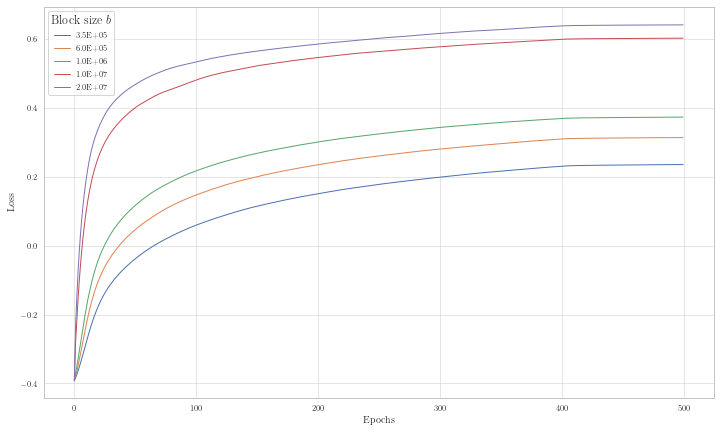

In [12]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['loss'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(title='Block size $b$')

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


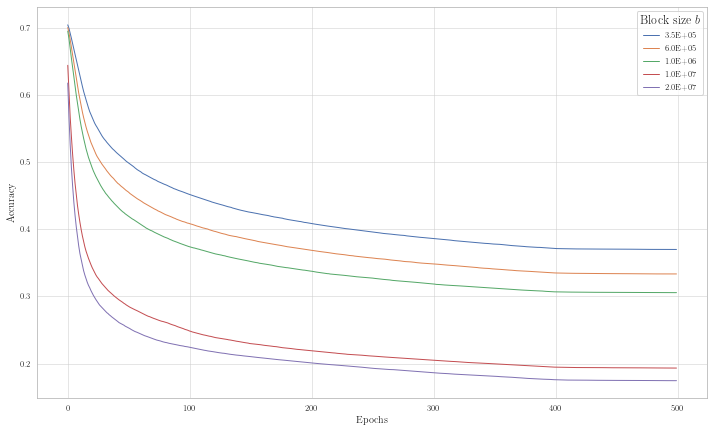

In [13]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['accuracy'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(title='Block size $b$')

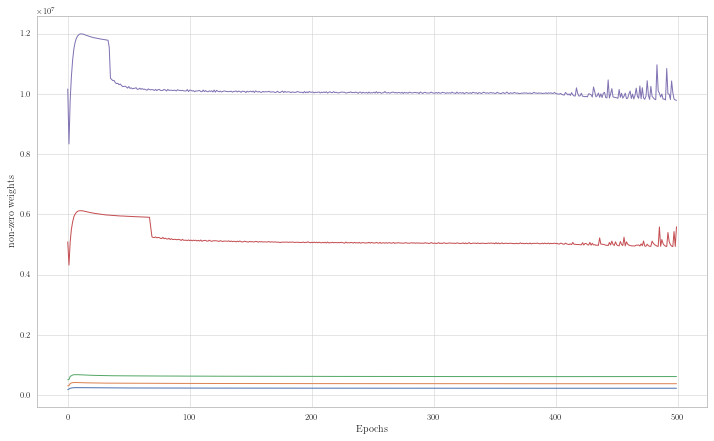

In [14]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['nonzero_weights'], label=search_space_size)
    plt.xlabel('Epochs')
    plt.ylabel('non-zero weights')

In [15]:
list(results[0].keys())

['loss', 'accuracy', 'nonzero_weights', 'expected_perturbations']

# Compensate block size with more epochs

In [ ]:
search_space_sizes = [1_000_000, 2_000_000, 10_000_000]
epochs = [1000, 500, 100]

results = []
for epoch, search_space_size in zip(epochs, search_space_sizes):
    temp_attack_params = dict(attack_params)
    temp_attack_params['search_space_size'] = search_space_size
    temp_attack_params['epochs'] = epoch
    adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels,
                              model=gcn, idx_attack=idx_test, device=device, **temp_attack_params)

    m = adj._nnz() / 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_perturbations = int(round(epsilon * m))
    adversary.attack(n_perturbations)
    
    results.append(adversary.attack_statistics)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


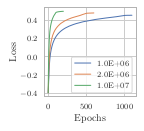

In [52]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size in zip(results, search_space_sizes):
    ax.plot(result['loss'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(title='Block size $b$')
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_no_legend', fig, close_fig=False)
    plt.legend()
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_legend',
        mod_label=lambda l: l,
        ncol=3
    )

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


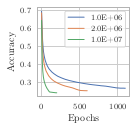

In [31]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size in zip(results, search_space_sizes):
    plt.plot(result['accuracy'], label=f'{search_space_size:.1E}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(title='Block size $b$')
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_no_legend', fig, close_fig=False)
    plt.legend()
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_legend',
        mod_label=lambda l: l,
        ncol=3
    )